In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## Загрузка данных

In [2]:
data = pd.read_csv('./data/amine_treatment-final.csv', on_bad_lines='skip')
data

,"feed_gas temperature, C","feed_gas pressure, kPa","feed_gas mass flow, kg/h",feed_gas molecular weight,"feed_gas Mass density, kg/m3","feed_gas actual liquid flow, m3/h","feed_gas actual vapour flow, m3/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,...,degased_amine Propane mol frac,degased_amine i-Butane mol frac,degased_amine n-Butane mol frac,degased_amine i-Pentane mol frac,degased_amine n-Pentane mol frac,degased_amine H2S mol frac,degased_amine H2O mol frac,degased_amine MDEAmine mol frac,degased_amine H2S ppm,degased_amine CO2 ppm
0,52.0,6701.325,259647.0,24.668523,80.705482,0.000000,3217.216383,0.031875,0.633122,0.192729,...,0.000004,1.979803e-06,6.785930e-06,3.039502e-08,1.629357e-07,0.014838,0.910916,0.062270,22521.880092,23245.607009
1,40.0,6701.325,63853.0,23.411939,79.292250,0.000000,805.286774,0.039520,0.681947,0.179992,...,0.000006,1.099164e-07,7.886635e-07,2.425456e-06,2.679624e-08,0.010470,0.896612,0.077190,15891.219056,30468.484150
2,46.0,6701.325,15928.0,27.803853,108.358884,0.000000,146.993024,0.027859,0.577870,0.163095,...,0.000018,5.179434e-05,2.863001e-05,4.721545e-06,1.359401e-06,0.001284,0.860268,0.132676,1949.372531,10648.306282
3,36.0,6701.325,150276.0,22.053344,74.092459,0.000000,2028.222609,0.005420,0.856717,0.000249,...,0.000039,8.734358e-06,3.706189e-05,5.426945e-05,3.949909e-06,0.001233,0.809722,0.184359,1871.528366,8438.736973
4,12.0,6701.325,52691.0,24.334510,114.182302,0.002870,461.460940,0.027297,0.694634,0.091063,...,0.000100,7.719691e-05,2.661312e-05,1.351350e-05,6.619552e-06,0.003300,0.788340,0.200715,5008.207346,14011.150105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512795,18.0,6701.325,278813.0,27.267819,147.437736,0.239690,1890.816202,0.036621,0.666807,0.042159,...,0.000053,1.226987e-04,3.336251e-05,4.145371e-06,8.510407e-06,0.002101,0.796328,0.187149,3188.443718,27411.897443
512796,33.0,6701.325,72612.0,26.629816,112.530303,0.000000,645.266193,0.025383,0.605142,0.150361,...,0.000049,8.271254e-05,1.199104e-05,1.810930e-06,4.749955e-06,0.003784,0.826966,0.162727,5742.847844,11941.343733
512797,17.0,6701.325,272718.0,26.290335,135.390018,0.133398,2014.180541,0.039356,0.606850,0.167318,...,0.000037,2.874297e-05,3.343060e-06,1.045919e-05,2.187381e-06,0.045335,0.725301,0.179546,68812.636471,97071.672175
512798,59.0,6701.325,75970.0,24.231673,73.727565,0.000000,1030.415146,0.037951,0.732049,0.086286,...,0.000013,1.782460e-05,8.286743e-06,5.417825e-06,2.393693e-07,0.002551,0.877567,0.106280,3871.441495,26287.366187


In [3]:
data_for_students = data.sample(frac=0.7)
data_for_students

,"feed_gas temperature, C","feed_gas pressure, kPa","feed_gas mass flow, kg/h",feed_gas molecular weight,"feed_gas Mass density, kg/m3","feed_gas actual liquid flow, m3/h","feed_gas actual vapour flow, m3/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,...,degased_amine Propane mol frac,degased_amine i-Butane mol frac,degased_amine n-Butane mol frac,degased_amine i-Pentane mol frac,degased_amine n-Pentane mol frac,degased_amine H2S mol frac,degased_amine H2O mol frac,degased_amine MDEAmine mol frac,degased_amine H2S ppm,degased_amine CO2 ppm
232512,35.0,6701.325,80891.0,26.224854,106.701944,0.000000,758.102400,0.007680,0.673544,0.106280,...,0.000023,0.000093,0.000045,1.494840e-05,5.267075e-07,0.002679,0.826100,0.168072,4066.049654,5294.708818
435756,46.0,6701.325,242062.0,25.033981,87.281080,0.000000,2773.361647,0.015245,0.666463,0.147085,...,0.000087,0.000103,0.000151,7.853618e-05,5.634176e-05,0.055451,0.628964,0.300844,84166.178539,27060.183702
28593,36.0,6701.325,262486.0,27.334602,120.568036,0.000000,2177.077837,0.009177,0.577961,0.195126,...,0.000070,0.000056,0.000008,3.830404e-05,7.735565e-06,0.009307,0.788484,0.195944,14126.248798,11259.568860
118912,44.0,6701.325,78193.0,24.132228,82.174285,0.000000,951.550715,0.014397,0.711596,0.103031,...,0.000037,0.000050,0.000034,2.253131e-05,9.215687e-06,0.006371,0.798846,0.190438,9670.675016,7592.128262
164709,21.0,6701.325,220125.0,26.971661,136.289192,0.176043,1614.955700,0.031220,0.684683,0.056134,...,0.000019,0.000015,0.000029,9.203068e-06,5.140688e-07,0.006030,0.836472,0.134491,9152.595028,44664.505608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353984,18.0,6701.325,138867.0,25.918325,127.134669,0.133184,1092.149517,0.034385,0.642143,0.115456,...,0.000050,0.000042,0.000034,6.384547e-07,1.292282e-06,0.003275,0.824517,0.160262,4970.310936,22706.874911
112559,24.0,6701.325,124549.0,23.387320,88.689953,0.097505,1404.221650,0.030127,0.778444,0.020839,...,0.000053,0.000178,0.000008,1.417805e-05,1.144724e-05,0.005458,0.788249,0.194723,8284.039699,21769.604987
338339,55.0,6701.325,298971.0,23.153108,70.581478,0.000000,4235.827996,0.017250,0.820230,0.011622,...,0.000002,0.000109,0.000090,5.546237e-05,1.613603e-06,0.030254,0.739313,0.216599,45920.708777,26242.304996
298370,58.0,6701.325,262327.0,26.480748,88.422943,0.000000,2966.730043,0.022448,0.596027,0.192353,...,0.000012,0.000079,0.000069,3.290666e-06,1.301982e-05,0.023546,0.764967,0.196419,35740.133111,28642.272963


In [4]:
data_for_students.to_csv('amine_treatment_student.csv')

In [3]:
list(data.columns)

['feed_gas temperature, C',
 'feed_gas pressure, kPa',
 'feed_gas mass flow, kg/h',
 'feed_gas molecular weight',
 'feed_gas Mass density, kg/m3',
 'feed_gas actual liquid flow, m3/h',
 'feed_gas actual vapour flow, m3/h',
 'feed_gas CO2 mol frac',
 'feed_gas Methane mol frac',
 'feed_gas Ethane mol frac',
 'feed_gas Propane mol frac',
 'feed_gas i-Butane mol frac',
 'feed_gas n-Butane mol frac',
 'feed_gas i-Pentane mol frac',
 'feed_gas n-Pentane mol frac',
 'feed_gas H2S mol frac',
 'feed_gas H2O mol frac',
 'feed_gas MDEAmine mol frac',
 'feed_gas H2S ppm',
 'feed_gas CO2 ppm',
 'Absorber number of stages',
 'lean_amine temperature, C',
 'lean_amine pressure, kPa',
 'lean_amine mass flow, kg/h',
 'lean_amine molecular weight',
 'lean_amine Mass density, kg/m3',
 'lean_amine actual liquid flow, m3/h',
 'lean_amine actual vapour flow, m3/h',
 'lean_amine CO2 mol frac',
 'lean_amine Methane mol frac',
 'lean_amine Ethane mol frac',
 'lean_amine Propane mol frac',
 'lean_amine i-Butane

In [4]:
student_data = data.sample(frac=0.25)
student_data.to_csv('student_amine_treatment.csv')

In [3]:
data['rich_amine molar flow, kgmol/h'] = data['rich_amine mass flow, kg/h'] / data['rich_amine molecular weight']
data['rich_amine H2S molar flow, kgmol/h'] = data['rich_amine molar flow, kgmol/h'] * data['rich_amine H2S mol frac']
data['rich_amine CO2 molar flow, kgmol/h'] = data['rich_amine molar flow, kgmol/h'] * data['rich_amine CO2 mol frac']
data['rich_amine H2O molar flow, kgmol/h'] = data['rich_amine molar flow, kgmol/h'] * data['rich_amine H2O mol frac']
data['rich_amine MDEAmine molar flow, kgmol/h'] = data['rich_amine molar flow, kgmol/h'] * data['rich_amine MDEAmine mol frac']
data['rich_amine sour comp molar flow, kgmol/h'] = data['rich_amine H2S molar flow, kgmol/h'] + data['rich_amine CO2 molar flow, kgmol/h']

data['feed_gas molar flow, kgmol/h'] = data['feed_gas mass flow, kg/h'] / data['feed_gas molecular weight']
data['feed_gas H2S molar flow, kgmol/h'] = data['feed_gas molar flow, kgmol/h'] * data['feed_gas H2S mol frac']
data['feed_gas CO2 molar flow, kgmol/h'] = data['feed_gas molar flow, kgmol/h'] * data['feed_gas CO2 mol frac']
data['feed_gas H2O molar flow, kgmol/h'] = data['feed_gas molar flow, kgmol/h'] * data['feed_gas H2O mol frac']
data['feed_gas MDEAmine molar flow, kgmol/h'] = data['feed_gas molar flow, kgmol/h'] * data['feed_gas MDEAmine mol frac']


data['lean_amine molar flow, kgmol/h'] = data['lean_amine mass flow, kg/h'] / data['lean_amine molecular weight']
data['lean_amine H2S molar flow, kgmol/h'] = data['lean_amine molar flow, kgmol/h'] * data['lean_amine H2S mol frac']
data['lean_amine CO2 molar flow, kgmol/h'] = data['lean_amine molar flow, kgmol/h'] * data['lean_amine CO2 mol frac']
data['lean_amine H2O molar flow, kgmol/h'] = data['lean_amine molar flow, kgmol/h'] * data['lean_amine H2O mol frac']
data['lean_amine MDEAmine molar flow, kgmol/h'] = data['lean_amine molar flow, kgmol/h'] * data['lean_amine MDEAmine mol frac']

data['sweet_gas molar flow, kgmol/h'] = data['sweet_gas mass flow, kg/h'] / data['sweet_gas molecular weight']
data['sweet_gas H2S molar flow, kgmol/h'] = data['sweet_gas molar flow, kgmol/h'] * data['sweet_gas H2S mol frac']
data['sweet_gas CO2 molar flow, kgmol/h'] = data['sweet_gas molar flow, kgmol/h'] * data['sweet_gas CO2 mol frac']
data['sweet_gas H2O molar flow, kgmol/h'] = data['sweet_gas molar flow, kgmol/h'] * data['sweet_gas H2O mol frac']
data['sweet_gas MDEAmine molar flow, kgmol/h'] = data['sweet_gas molar flow, kgmol/h'] * data['sweet_gas MDEAmine mol frac']

## Модель для определения температуры продуктов

In [6]:
mini_data = data.sample(frac=0.45)
len(mini_data)

230760

In [7]:
sulphur = data[['feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac',
                'feed_gas Methane mol frac', 'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 
                'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac', 'feed_gas i-Pentane mol frac',
                'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
                'feed_gas MDEAmine mol frac',
                'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
                'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
                'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
                'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac',
                'lean_amine MDEAmine mol frac',
                'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h', 'feed_gas CO2 molar flow, kgmol/h',
                'feed_gas H2O molar flow, kgmol/h', 'feed_gas MDEAmine molar flow, kgmol/h',
                'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
                'lean_amine CO2 molar flow, kgmol/h', 'lean_amine H2O molar flow, kgmol/h',
                'lean_amine MDEAmine molar flow, kgmol/h',                
                'sweet_gas temperature, C', 'rich_amine temperature, C'
               ]]

X = sulphur[[
                'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac',
                'feed_gas Methane mol frac', 'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 
                'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac', 'feed_gas i-Pentane mol frac',
                'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
                'feed_gas MDEAmine mol frac',
                'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
                'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
                'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
                'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac',
                'lean_amine MDEAmine mol frac',
                'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h', 'feed_gas CO2 molar flow, kgmol/h',
                'feed_gas H2O molar flow, kgmol/h', 'feed_gas MDEAmine molar flow, kgmol/h',
                'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
                'lean_amine CO2 molar flow, kgmol/h', 'lean_amine H2O molar flow, kgmol/h',
                'lean_amine MDEAmine molar flow, kgmol/h',     
]]

y = sulphur[['sweet_gas temperature, C', 'rich_amine temperature, C']]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), ['feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac',
                'feed_gas Methane mol frac', 'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 
                'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac', 'feed_gas i-Pentane mol frac',
                'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
                'feed_gas MDEAmine mol frac',
                'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
                'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
                'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
                'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac',
                'lean_amine MDEAmine mol frac',
                'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h', 'feed_gas CO2 molar flow, kgmol/h',
                'feed_gas H2O molar flow, kgmol/h', 'feed_gas MDEAmine molar flow, kgmol/h',
                'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
                'lean_amine CO2 molar flow, kgmol/h', 'lean_amine H2O molar flow, kgmol/h',
                'lean_amine MDEAmine molar flow, kgmol/h',])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((410240, 36), (410240, 2))

In [34]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
prod_temp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(36, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
prod_temp_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
prod_temp_model.fit(X_train_normal, y_train, epochs=100)

Epoch 1/100
12820/12820 [==============================] - 28s 2ms/step - loss: 3.2828 - mae: 3.2828
Epoch 2/100
12820/12820 [==============================] - 25s 2ms/step - loss: 2.4202 - mae: 2.4202
Epoch 3/100
12820/12820 [==============================] - 27s 2ms/step - loss: 2.3136 - mae: 2.3136
Epoch 4/100
12820/12820 [==============================] - 26s 2ms/step - loss: 2.1243 - mae: 2.1243
Epoch 5/100
12820/12820 [==============================] - 25s 2ms/step - loss: 1.5521 - mae: 1.5521
Epoch 6/100
12820/12820 [==============================] - 26s 2ms/step - loss: 1.4853 - mae: 1.4853
Epoch 7/100
12820/12820 [==============================] - 25s 2ms/step - loss: 1.4431 - mae: 1.4431
Epoch 8/100
12820/12820 [==============================] - 26s 2ms/step - loss: 1.4218 - mae: 1.4218
Epoch 9/100
12820/12820 [==============================] - 26s 2ms/step - loss: 1.4051 - mae: 1.4051
Epoch 10/100
12820/12820 [==============================] - 24s 2ms/step - loss: 1.3857 - m

In [35]:
y_pred = prod_temp_model.predict(X_test_normal)

3205/3205 [==============================] - 5s 1ms/step


In [51]:
x = 438
pred = y_pred[x]
pred

array([37.08214 , 43.736782], dtype=float32)

In [52]:
test = y_test.iloc[x]
test

sweet_gas temperature, C     38.208567
rich_amine temperature, C    46.307358
Name: 466174, dtype: float64

In [53]:
100 - ((pred * 100) / test)

sweet_gas temperature, C     2.948098
rich_amine temperature, C    5.551117
Name: 466174, dtype: float64

In [54]:
prod_temp_model.save('./models/amine_treatment/amine_treatment_prod_temp_model.h5')

In [12]:
sulphur_data = sulphur.sample(frac=0.01)
sulphur_data

,"feed_gas temperature, C","feed_gas mass flow, kg/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,feed_gas Propane mol frac,feed_gas i-Butane mol frac,feed_gas n-Butane mol frac,feed_gas i-Pentane mol frac,feed_gas n-Pentane mol frac,...,lean_amine Propane mol frac,lean_amine i-Butane mol frac,lean_amine n-Butane mol frac,lean_amine i-Pentane mol frac,lean_amine n-Pentane mol frac,lean_amine H2S mol frac,lean_amine H2O mol frac,lean_amine MDEAmine mol frac,"sweet_gas temperature, C","rich_amine temperature, C"
229777,59.0,295333.0,0.037486,0.709195,0.027945,0.049124,0.096944,0.016101,0.022952,0.004392,...,0.0,0.0,0.0,0.0,0.0,0.000211,0.977453,0.019753,63.534447,65.537233
230248,22.0,51765.0,0.036442,0.649914,0.060758,0.072099,0.052338,0.046696,0.041313,0.003336,...,0.0,0.0,0.0,0.0,0.0,0.000344,0.810059,0.184826,25.056876,30.451538
142441,53.0,94584.0,0.026240,0.633435,0.186715,0.090658,0.019003,0.011180,0.025023,0.002668,...,0.0,0.0,0.0,0.0,0.0,0.000291,0.890271,0.108304,26.411256,36.111568
236140,39.0,135235.0,0.028697,0.800068,0.024626,0.082167,0.009194,0.023052,0.017758,0.006773,...,0.0,0.0,0.0,0.0,0.0,0.000181,0.839054,0.157503,35.072823,45.195079
328006,50.0,27226.0,0.024775,0.728327,0.096035,0.039802,0.018610,0.062545,0.017170,0.009563,...,0.0,0.0,0.0,0.0,0.0,0.000238,0.899695,0.097257,40.644903,46.896273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127774,57.0,106247.0,0.007134,0.564712,0.150123,0.092254,0.052006,0.076666,0.035214,0.003127,...,0.0,0.0,0.0,0.0,0.0,0.000139,0.860390,0.136670,33.316939,47.659560
340722,12.0,139188.0,0.014490,0.654710,0.126441,0.074161,0.058075,0.011644,0.014428,0.007704,...,0.0,0.0,0.0,0.0,0.0,0.000116,0.858768,0.137278,23.306435,25.228895
460614,20.0,278135.0,0.020406,0.661170,0.083639,0.022305,0.068197,0.078623,0.049696,0.000717,...,0.0,0.0,0.0,0.0,0.0,0.000386,0.845761,0.152531,21.611649,26.587039
437188,43.0,94367.0,0.028831,0.658443,0.177795,0.036555,0.024317,0.051922,0.007627,0.000021,...,0.0,0.0,0.0,0.0,0.0,0.000317,0.980460,0.017175,32.290935,35.745604


In [13]:
sulphur_data.to_csv('sulphur_data.csv')

## Модель для определения массовых расходов продуктовых потоков

In [8]:
mini_data = data.sample(frac=0.85)
len(mini_data)

435880

In [9]:
prod_mass_flow = data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'sweet_gas temperature, C', 'rich_amine temperature, C',
    'rich_amine mass flow, kg/h', 'sweet_gas mass flow, kg/h'
]]

X = prod_mass_flow[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'sweet_gas temperature, C', 'rich_amine temperature, C',
]]

y = prod_mass_flow[['rich_amine mass flow, kg/h']]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'sweet_gas temperature, C', 'rich_amine temperature, C',
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((410240, 28), (410240, 1))

In [10]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
rich_amine_mass_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
rich_amine_mass_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
rich_amine_mass_flow_model.fit(X_train_normal, y_train, epochs=20)

Epoch 1/20
12820/12820 [==============================] - 33s 2ms/step - loss: 14287.3623 - mae: 14287.3623
Epoch 2/20
12820/12820 [==============================] - 27s 2ms/step - loss: 1538.5583 - mae: 1538.5583
Epoch 3/20
12820/12820 [==============================] - 28s 2ms/step - loss: 1356.8630 - mae: 1356.8630
Epoch 4/20
12820/12820 [==============================] - 27s 2ms/step - loss: 1260.5762 - mae: 1260.5762
Epoch 5/20
12820/12820 [==============================] - 28s 2ms/step - loss: 1234.1326 - mae: 1234.1326
Epoch 6/20
12820/12820 [==============================] - 28s 2ms/step - loss: 1208.3176 - mae: 1208.3176
Epoch 7/20
12820/12820 [==============================] - 27s 2ms/step - loss: 1193.7108 - mae: 1193.7108
Epoch 8/20
12820/12820 [==============================] - 29s 2ms/step - loss: 1167.3158 - mae: 1167.3158
Epoch 9/20
12820/12820 [==============================] - 42s 3ms/step - loss: 1162.7391 - mae: 1162.7391
Epoch 10/20
12820/12820 [===================

In [11]:
y_pred = rich_amine_mass_flow_model.predict(X_test_normal)

3205/3205 [==============================] - 6s 2ms/step


In [12]:
y_pred

array([[508675.6  ],
       [187833.55 ],
       [514541.1  ],
       ...,
       [ 49514.227],
       [288734.84 ],
       [702899.06 ]], dtype=float32)

In [28]:
y_pred_small = y_pred[:50]
len(y_pred_small)

50

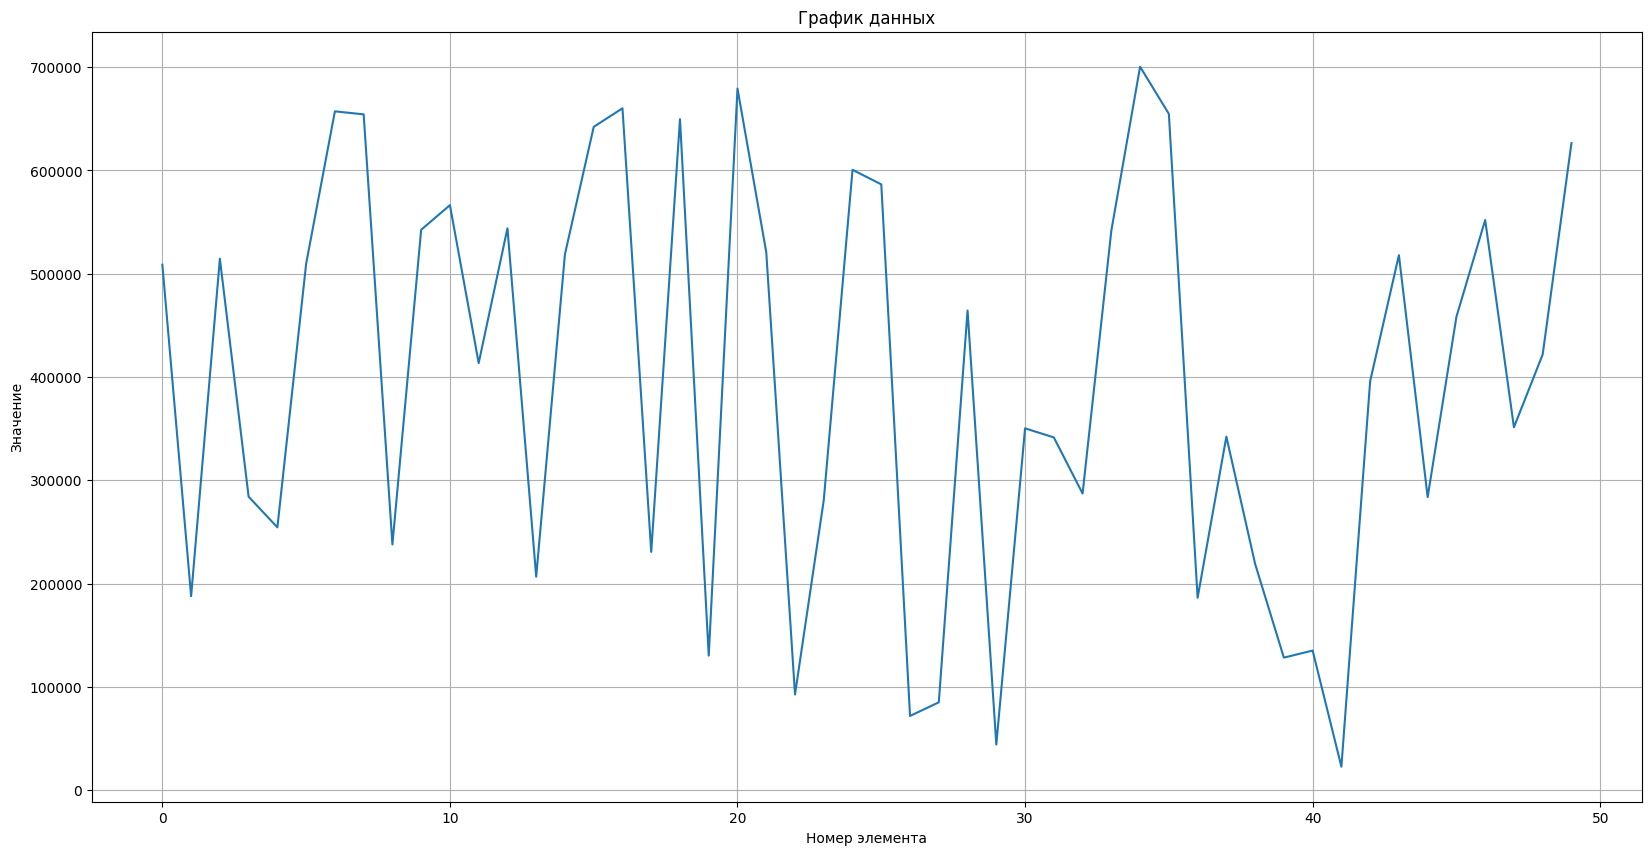

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(y_pred_small)
plt.xlabel('Номер элемента')
plt.ylabel('Значение')
plt.title('График данных')
plt.grid(True)
plt.show()

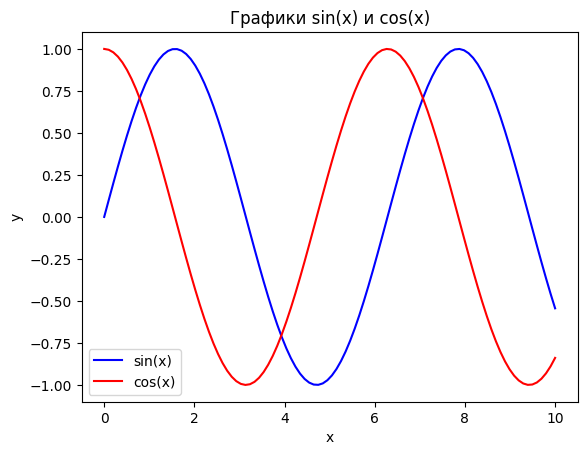

In [25]:
# Генерация данных для первого графика
x1 = np.linspace(0, 10, 100)
y1 = np.sin(x1)

# Генерация данных для второго графика
x2 = np.linspace(0, 10, 100)
y2 = np.cos(x2)

# Создание графика и добавление первого графика
plt.plot(x1, y1, label='sin(x)', color='blue')

# Добавление второго графика
plt.plot(x2, y2, label='cos(x)', color='red')

# Добавление легенды
plt.legend()

# Настройка меток осей и заголовка
plt.xlabel('x')
plt.ylabel('y')
plt.title('Графики sin(x) и cos(x)')

# Отображение графиков
plt.show()

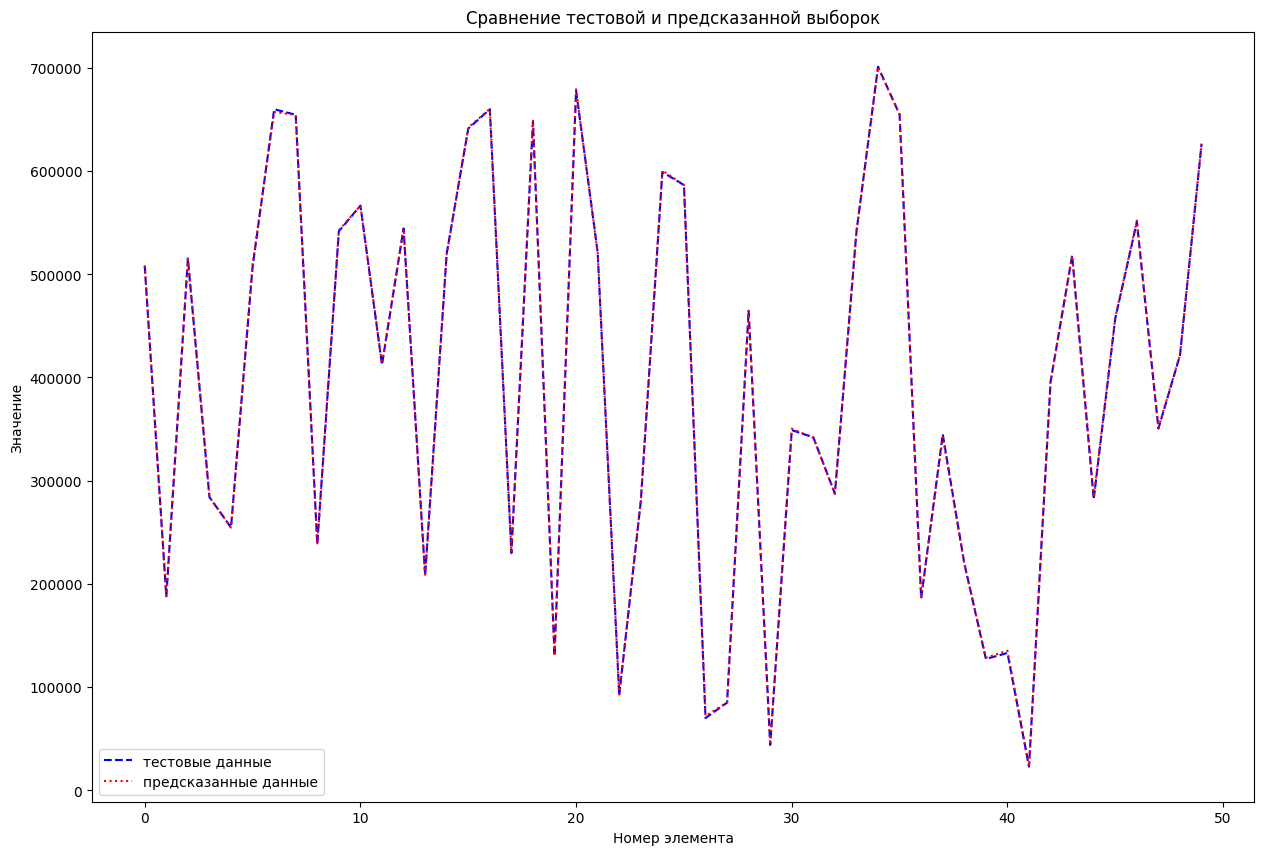

In [41]:
# Количество элементов в выборке
number_of_values = 50

# Данные для тестовой выборки
test_data = y_test.values[:number_of_values]

# Данные для предсказанной выборки
pred_data = y_pred[:number_of_values]

# Данные для оси X
x = np.arange(len(pred_data))

plt.figure(figsize=(15, 10))

# График для тестовой выборки
plt.plot(x, test_data, label='тестовые данные', color='blue', linestyle='--')

# График для предсказанной выборки
plt.plot(x, pred_data, label='предсказанные данные', color='red', linestyle='dotted')

# Настройка меток осей и заголовка
plt.xlabel('Номер элемента')
plt.ylabel('Значение')
plt.title('Сравнение тестовой и предсказанной выборок')

# Добавление легенды
plt.legend(loc='lower left')

# Отображение графиков
plt.show()

In [120]:
x = 1098
y_pred[x]

array([325158.9], dtype=float32)

In [121]:
y_test.iloc[x]

rich_amine mass flow, kg/h    325148.650133
Name: 478285, dtype: float64

In [119]:
(543540.56 * 100) / 544287.473182

99.86277229978612

In [122]:
rich_amine_mass_flow_model.save('./models/amine_treatment/amine_treatment_rich_amine_mass_flow.h5')

In [15]:
rich_amine_mass_flow_data = prod_mass_flow.sample(frac=0.01)
rich_amine_mass_flow_data

,"feed_gas temperature, C","feed_gas mass flow, kg/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,feed_gas Propane mol frac,feed_gas i-Butane mol frac,feed_gas n-Butane mol frac,feed_gas i-Pentane mol frac,feed_gas n-Pentane mol frac,...,lean_amine n-Butane mol frac,lean_amine i-Pentane mol frac,lean_amine n-Pentane mol frac,lean_amine H2S mol frac,lean_amine H2O mol frac,lean_amine MDEAmine mol frac,"sweet_gas temperature, C","rich_amine temperature, C","rich_amine mass flow, kg/h","sweet_gas mass flow, kg/h"
378785,34.0,43352.0,0.028730,0.730447,0.055514,0.099421,0.025227,0.001636,0.017257,0.008542,...,0.0,0.0,0.0,0.000222,0.828388,0.167117,34.640048,44.629556,172799.511011,39440.488989
118926,41.0,169862.0,0.027947,0.741430,0.005786,0.021576,0.059063,0.082672,0.021086,0.002751,...,0.0,0.0,0.0,0.000306,0.943323,0.055319,40.024375,40.382760,31566.931899,167568.068101
484677,19.0,200299.0,0.035638,0.743175,0.002663,0.036137,0.034679,0.079880,0.045699,0.009657,...,0.0,0.0,0.0,0.000229,0.791924,0.206932,43.867206,42.554392,357737.285549,186419.714451
172004,37.0,15602.0,0.038805,0.632071,0.137268,0.029537,0.032185,0.080976,0.027329,0.001191,...,0.0,0.0,0.0,0.000115,0.963816,0.034689,49.918045,53.411792,84879.752815,14220.247185
373724,18.0,276450.0,0.035284,0.517867,0.154605,0.041304,0.064756,0.092810,0.045651,0.008637,...,0.0,0.0,0.0,0.000143,0.974992,0.022430,34.287812,24.770478,496446.706692,256522.293308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98277,29.0,160620.0,0.014560,0.737626,0.059342,0.011977,0.099359,0.038867,0.029087,0.002439,...,0.0,0.0,0.0,0.000156,0.790771,0.208055,36.000133,36.903628,634442.178968,155221.821032
179710,22.0,196540.0,0.019006,0.726973,0.005725,0.074952,0.027308,0.098185,0.008860,0.004578,...,0.0,0.0,0.0,0.000247,0.810191,0.188147,17.920779,45.870836,222515.108397,181618.891603
158766,45.0,284251.0,0.009030,0.767586,0.016812,0.053575,0.048981,0.028589,0.045822,0.009651,...,0.0,0.0,0.0,0.000342,0.752415,0.243823,45.985001,57.590519,354210.540020,273610.459980
298377,59.0,118392.0,0.007394,0.757411,0.025888,0.020194,0.060058,0.061593,0.037414,0.001076,...,0.0,0.0,0.0,0.000333,0.755419,0.242670,16.736872,66.343628,154380.854558,112142.145442


In [16]:
rich_amine_mass_flow_data.to_csv('rich_amine_mass_flow_data.csv')

## Модель для определения молярного расхода H2S и CO2 в продуктовых потоках

In [8]:
mini_data = data.sample(frac=1)
len(mini_data)

512800

In [9]:
sour_comp = mini_data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'rich_amine H2S molar flow, kgmol/h', 'rich_amine CO2 molar flow, kgmol/h',
]]

In [10]:
X = sour_comp[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
]]

y = sour_comp[['rich_amine H2S molar flow, kgmol/h']]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((410240, 38), (410240, 1))

In [69]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
rich_amine_sour_comp_molar_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(38, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
rich_amine_sour_comp_molar_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
rich_amine_sour_comp_molar_flow_model.fit(X_train_normal, y_train, epochs=20)

Epoch 1/20
12820/12820 [==============================] - 35s 3ms/step - loss: 5.1403 - mae: 5.1403
Epoch 2/20
12820/12820 [==============================] - 34s 3ms/step - loss: 2.3638 - mae: 2.3638
Epoch 3/20
12820/12820 [==============================] - 37s 3ms/step - loss: 2.0116 - mae: 2.0116
Epoch 4/20
12820/12820 [==============================] - 37s 3ms/step - loss: 1.8198 - mae: 1.8198
Epoch 5/20
12820/12820 [==============================] - 35s 3ms/step - loss: 1.6952 - mae: 1.6952
Epoch 6/20
12820/12820 [==============================] - 35s 3ms/step - loss: 1.6172 - mae: 1.6172
Epoch 7/20
12820/12820 [==============================] - 35s 3ms/step - loss: 1.5220 - mae: 1.5220
Epoch 8/20
12820/12820 [==============================] - 37s 3ms/step - loss: 1.4954 - mae: 1.4954
Epoch 9/20
12820/12820 [==============================] - 35s 3ms/step - loss: 1.4371 - mae: 1.4371
Epoch 10/20
12820/12820 [==============================] - 36s 3ms/step - loss: 1.4094 - mae: 1.4094

In [70]:
y_pred = rich_amine_sour_comp_molar_flow_model.predict(X_test_normal)

3205/3205 [==============================] - 4s 1ms/step


In [86]:
x = 213
pred = y_pred[x]
pred

array([332.17758], dtype=float32)

In [87]:
test = y_test.iloc[x]
test

rich_amine H2S molar flow, kgmol/h    332.101716
Name: 440004, dtype: float64

In [88]:
100 - (pred * 100) / test

rich_amine H2S molar flow, kgmol/h   -0.022843
Name: 440004, dtype: float64

In [38]:
rich_amine_sour_comp_molar_flow_model.save('./models/amine_treatment/amine_treatment_rich_amine_sour_molar_flow_model.h5')

In [39]:
sour_components = sour_comp.sample(frac=0.01)
sour_components

,"feed_gas temperature, C","feed_gas mass flow, kg/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,feed_gas Propane mol frac,feed_gas i-Butane mol frac,feed_gas n-Butane mol frac,feed_gas i-Pentane mol frac,feed_gas n-Pentane mol frac,...,lean_amine molecular weight,"lean_amine molar flow, kgmol/h","lean_amine H2S molar flow, kgmol/h","lean_amine CO2 molar flow, kgmol/h","rich_amine temperature, C","rich_amine mass flow, kg/h",rich_amine molecular weight,"rich_amine molar flow, kgmol/h","rich_amine H2S molar flow, kgmol/h","rich_amine CO2 molar flow, kgmol/h"
105404,38.0,290380.0,0.036568,0.633979,0.137327,0.061714,0.029882,0.034817,0.048369,0.009642,...,22.913307,13414.912062,2.023831,47.203425,45.652949,317240.254677,23.222830,13660.706109,85.017657,202.557334
385764,33.0,42259.0,0.025983,0.763811,0.011568,0.049912,0.070963,0.006874,0.026613,0.008851,...,23.066133,17359.260354,1.951223,36.419811,29.870549,404724.200559,23.145906,17485.779076,60.859249,76.277822
479560,21.0,115836.0,0.038906,0.736376,0.110214,0.002975,0.048955,0.008792,0.037611,0.004681,...,32.102040,2602.949822,0.730669,10.606993,37.044573,91133.274166,32.747253,2782.928861,52.992684,143.772860
362872,56.0,15374.0,0.012368,0.663892,0.042176,0.094753,0.087871,0.015755,0.044200,0.007991,...,31.369812,4426.931243,1.159716,19.573218,41.476543,139952.768425,31.384394,4459.310854,17.743862,25.768883
336249,42.0,296616.0,0.014922,0.850425,0.014328,0.005478,0.041344,0.022285,0.019956,0.007407,...,36.098086,6968.568875,1.572994,28.235581,56.865982,264617.241609,36.073996,7335.401426,311.195083,80.970177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427927,59.0,110482.0,0.035233,0.693293,0.034714,0.020443,0.095918,0.056986,0.040347,0.006213,...,30.679354,21653.552387,3.817432,42.757885,65.145809,673060.385212,30.765480,21877.129538,69.985822,167.289608
448680,44.0,265403.0,0.005207,0.853698,0.035997,0.028232,0.011833,0.005959,0.043152,0.001840,...,32.404044,12139.225597,2.915448,34.754251,47.612990,400540.673718,32.423508,12353.403485,164.625585,59.205789
432777,18.0,118877.0,0.033289,0.690449,0.172608,0.006984,0.037546,0.027818,0.024623,0.005666,...,30.191675,4207.981139,1.582449,14.024740,25.918228,130299.944255,30.388377,4287.821799,3.597292,81.061772
456855,13.0,202654.0,0.008855,0.692533,0.095531,0.005269,0.086568,0.048374,0.016737,0.007719,...,28.323658,5904.533911,1.742558,12.483652,31.145991,180309.122918,28.775452,6266.074450,306.259928,74.405332


In [40]:
sour_components.to_csv('sour_components_data.csv')

In [11]:
# Определение концентрации кислых компонентов в очищенном газе

In [4]:
mini_data = data.sample(frac=1)
len(mini_data)

512800

In [5]:
sour_comp = mini_data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    'sweet_gas H2S ppm'
]]

In [6]:
x = 10
print(list(mini_data['feed_gas H2S molar flow, kgmol/h'])[x])
print(' ')
print(list(mini_data['lean_amine H2S molar flow, kgmol/h'])[x])
print(' ')
print(list(mini_data['sweet_gas H2S molar flow, kgmol/h'])[x])
print(' ')
print(list(mini_data['rich_amine H2S molar flow, kgmol/h'])[x])
print(' ')

print('SUMM INLET', list(mini_data['feed_gas H2S molar flow, kgmol/h'])[x] + list(mini_data['lean_amine H2S molar flow, kgmol/h'])[x])
print('SUMM OUTLET', list(mini_data['sweet_gas H2S molar flow, kgmol/h'])[x] + list(mini_data['rich_amine H2S molar flow, kgmol/h'])[x])

109.63124596152917
 
2.827907910262469
 
0.1476378091408464
 
112.31151606265166
 
SUMM INLET 112.45915387179164
SUMM OUTLET 112.45915387179251


In [7]:
X = sour_comp[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
]]

y = np.log1p(sour_comp[['sweet_gas H2S ppm']])

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((410240, 42), (410240, 1))

In [8]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sweet_gas_H2S_ppm_model = tf.keras.Sequential([
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
sweet_gas_H2S_ppm_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sweet_gas_H2S_ppm_model.fit(X_train_normal, y_train, epochs=20)

Epoch 1/20
12820/12820 [==============================] - 16s 1ms/step - loss: 0.2419 - mae: 0.2419
Epoch 2/20
12820/12820 [==============================] - 16s 1ms/step - loss: 0.1501 - mae: 0.1501
Epoch 3/20
12820/12820 [==============================] - 19s 1ms/step - loss: 0.1309 - mae: 0.1309
Epoch 4/20
12820/12820 [==============================] - 17s 1ms/step - loss: 0.1199 - mae: 0.1199
Epoch 5/20
12820/12820 [==============================] - 17s 1ms/step - loss: 0.1125 - mae: 0.1125
Epoch 6/20
12820/12820 [==============================] - 16s 1ms/step - loss: 0.1082 - mae: 0.1082
Epoch 7/20
12820/12820 [==============================] - 17s 1ms/step - loss: 0.1030 - mae: 0.1030
Epoch 8/20
12820/12820 [==============================] - 17s 1ms/step - loss: 0.1002 - mae: 0.1002
Epoch 9/20
12820/12820 [==============================] - 17s 1ms/step - loss: 0.0975 - mae: 0.0975
Epoch 10/20
12820/12820 [==============================] - 17s 1ms/step - loss: 0.0954 - mae: 0.0954

In [9]:
y_pred = sweet_gas_H2S_ppm_model.predict(X_test_normal)

3205/3205 [==============================] - 3s 833us/step


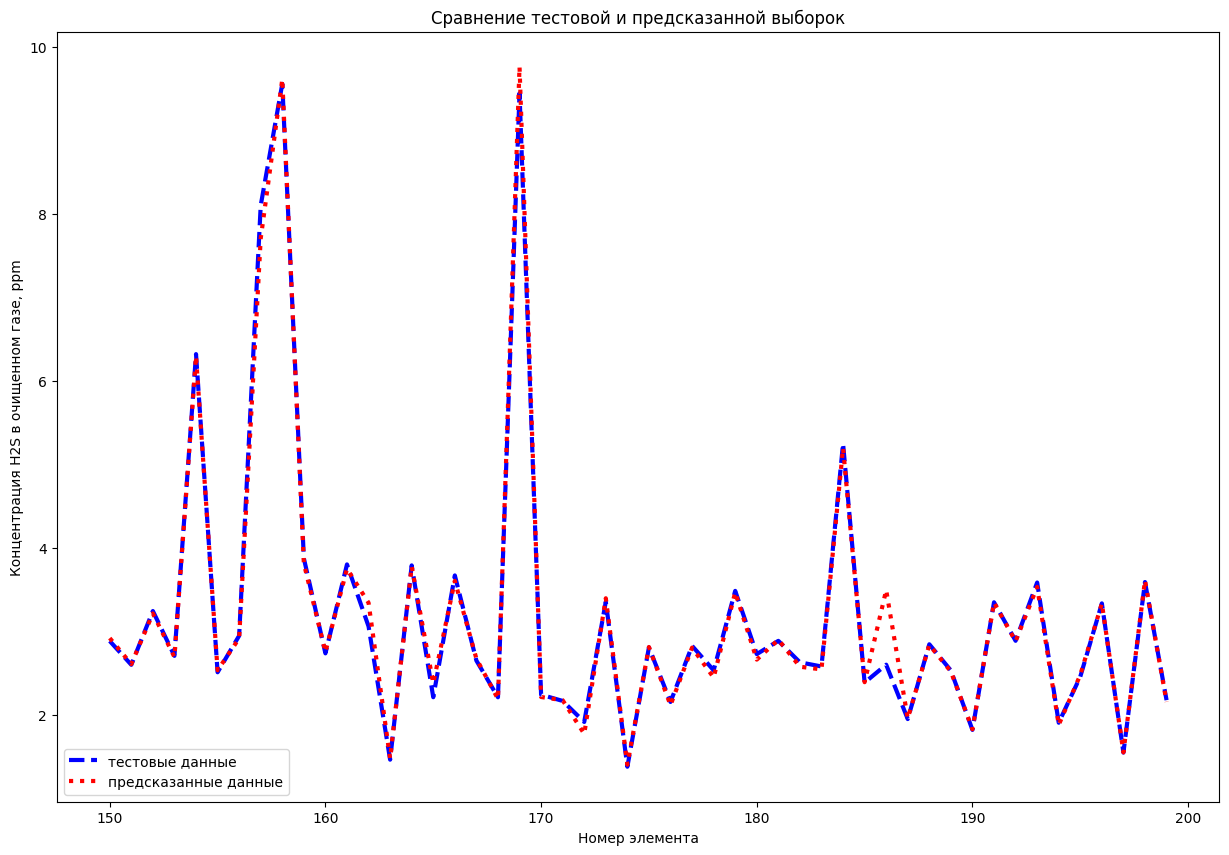

In [10]:
# Количество элементов в выборке
number_of_values = 150

# Данные для тестовой выборки
test_data = y_test.values[number_of_values:200]

# Данные для предсказанной выборки
pred_data = y_pred[number_of_values:200]

# Данные для оси X
x = np.arange(150, 200)

plt.figure(figsize=(15, 10))

# График для тестовой выборки
plt.plot(x, test_data, label='тестовые данные', color='blue', linestyle='--', linewidth=3)

# График для предсказанной выборки
plt.plot(x, pred_data, label='предсказанные данные', color='red', linestyle='dotted', linewidth=3)

# Настройка меток осей и заголовка
plt.xlabel('Номер элемента')
plt.ylabel('Концентрация H2S в очищенном газе, ppm')
plt.title('Сравнение тестовой и предсказанной выборок')

# Добавление легенды
plt.legend(loc='lower left')

# Отображение графиков
plt.show()

In [29]:
x = 783
pred = y_pred[x]
pred

array([2.445222], dtype=float32)

In [30]:
test = y_test.iloc[x]
test

sweet_gas H2S ppm    2.409552
Name: 73052, dtype: float64

In [21]:
100 - (pred * 100) / test

sweet_gas H2S ppm   -0.210624
Name: 3575, dtype: float64

In [22]:
sweet_gas_H2S_ppm_model.save('./models/amine_treatment/sweet_gas_H2S_ppm_model.h5')

In [23]:
sweet_gas_H2S_ppm = sour_comp.sample(frac=0.01)
sweet_gas_H2S_ppm

,"feed_gas temperature, C","feed_gas mass flow, kg/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,feed_gas Propane mol frac,feed_gas i-Butane mol frac,feed_gas n-Butane mol frac,feed_gas i-Pentane mol frac,feed_gas n-Pentane mol frac,...,"lean_amine CO2 molar flow, kgmol/h","rich_amine temperature, C","rich_amine mass flow, kg/h",rich_amine molecular weight,"rich_amine molar flow, kgmol/h","sweet_gas temperature, C","sweet_gas mass flow, kg/h",sweet_gas molecular weight,"sweet_gas molar flow, kgmol/h",sweet_gas H2S ppm
389910,44.0,138431.0,0.017740,0.577544,0.195338,0.052572,0.034059,0.086633,0.025220,0.002647,...,49.654798,31.111766,481531.423808,28.622220,16823.692084,19.215788,132775.576192,27.240774,4874.148526,3.082443
167068,48.0,107446.0,0.020797,0.653190,0.068358,0.015404,0.070850,0.093600,0.042065,0.008175,...,6.405164,63.352306,114846.706620,32.431237,3541.237295,31.489493,101014.293380,27.803750,3633.117539,13.614469
2612,59.0,177341.0,0.009573,0.716213,0.040274,0.058899,0.088299,0.041082,0.030593,0.004022,...,25.267539,44.863430,329050.852759,37.092843,8871.006578,10.751701,173005.147241,25.939032,6669.684037,4.533770
322124,41.0,288592.0,0.009698,0.786264,0.026881,0.003460,0.091304,0.036969,0.018378,0.007517,...,45.816390,56.679429,461499.098417,38.482491,11992.443484,56.580209,278183.901583,23.680127,11747.567824,61.503719
87917,53.0,294406.0,0.020563,0.570876,0.186446,0.008306,0.079993,0.096151,0.003451,0.009527,...,21.841168,63.843045,504518.711181,33.751541,14948.019922,54.449849,279825.288819,27.680825,10108.993747,13.450880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99532,49.0,203631.0,0.009946,0.745599,0.132434,0.010517,0.030903,0.009944,0.016416,0.004722,...,78.770093,45.857491,674862.496327,37.709156,17896.515333,32.147349,188134.503673,21.451962,8770.037119,6.332463
318167,22.0,252925.0,0.021603,0.543582,0.143615,0.056419,0.054561,0.095355,0.046707,0.008289,...,30.936046,27.174999,314306.157054,37.630432,8352.446082,31.605380,240776.842946,29.939463,8042.123030,5.736032
123198,30.0,39707.0,0.028794,0.644874,0.152438,0.038984,0.038082,0.045403,0.035308,0.003277,...,46.304319,23.970583,218803.025811,22.426673,9756.374691,18.405703,36991.974189,25.435707,1454.332430,10.617718
385326,29.0,89136.0,0.013247,0.784803,0.046519,0.045989,0.039022,0.013427,0.008095,0.009549,...,13.706979,27.406046,388174.014433,24.767913,15672.455423,18.358548,81717.985567,21.570182,3788.469951,2.014279


In [24]:
sweet_gas_H2S_ppm.to_csv('sweet_gas_H2S_ppm_data.csv')

In [26]:
mini_data = data.sample(frac=1)
len(mini_data)

512800

In [27]:
sour_comp = mini_data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    'sweet_gas CO2 ppm'
]]

X = sour_comp[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
]]

y = np.log1p(sour_comp[['sweet_gas CO2 ppm']])

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h', 'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((410240, 42), (410240, 1))

In [29]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sweet_gas_CO2_ppm_model = tf.keras.Sequential([
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
sweet_gas_CO2_ppm_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sweet_gas_CO2_ppm_model.fit(X_train_normal, y_train, epochs=50)

Epoch 1/50
12820/12820 [==============================] - 36s 3ms/step - loss: 0.5517 - mae: 0.5517
Epoch 2/50
12820/12820 [==============================] - 34s 3ms/step - loss: 0.4919 - mae: 0.4919
Epoch 3/50
12820/12820 [==============================] - 36s 3ms/step - loss: 0.4148 - mae: 0.4148
Epoch 4/50
12820/12820 [==============================] - 34s 3ms/step - loss: 0.3538 - mae: 0.3538
Epoch 5/50
12820/12820 [==============================] - 35s 3ms/step - loss: 0.3338 - mae: 0.3338
Epoch 6/50
12820/12820 [==============================] - 34s 3ms/step - loss: 0.3187 - mae: 0.3187
Epoch 7/50
12820/12820 [==============================] - 33s 3ms/step - loss: 0.3028 - mae: 0.3028
Epoch 8/50
12820/12820 [==============================] - 35s 3ms/step - loss: 0.2986 - mae: 0.2986
Epoch 9/50
12820/12820 [==============================] - 38s 3ms/step - loss: 0.2854 - mae: 0.2854
Epoch 10/50
12820/12820 [==============================] - 35s 3ms/step - loss: 0.2745 - mae: 0.2745

In [30]:
y_pred = sweet_gas_CO2_ppm_model.predict(X_test_normal)

3205/3205 [==============================] - 4s 1ms/step


In [52]:
x = 1323
pred = y_pred[x]
pred

array([7.6662226], dtype=float32)

In [53]:
test = y_test.iloc[x]
test

sweet_gas CO2 ppm    8.312111
Name: 461050, dtype: float64

In [54]:
100 - (pred * 100) / test

sweet_gas CO2 ppm    7.770451
Name: 461050, dtype: float64

In [55]:
sweet_gas_CO2_ppm_model.save('./models/amine_treatment/sweet_gas_CO2_ppm_model.h5')

In [56]:
sweet_gas_CO2_ppm = sour_comp.sample(frac=0.01)
sweet_gas_CO2_ppm

,"feed_gas temperature, C","feed_gas mass flow, kg/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,feed_gas Propane mol frac,feed_gas i-Butane mol frac,feed_gas n-Butane mol frac,feed_gas i-Pentane mol frac,feed_gas n-Pentane mol frac,...,"lean_amine CO2 molar flow, kgmol/h","rich_amine temperature, C","rich_amine mass flow, kg/h",rich_amine molecular weight,"rich_amine molar flow, kgmol/h","sweet_gas temperature, C","sweet_gas mass flow, kg/h",sweet_gas molecular weight,"sweet_gas molar flow, kgmol/h",sweet_gas CO2 ppm
110439,21.0,6621.0,0.031957,0.792016,0.038100,0.026709,0.009832,0.067482,0.023750,0.001595,...,47.951880,20.474792,573432.680960,35.872133,15985.463916,20.089028,5160.319040,22.294663,231.459840,633.768896
471425,36.0,50033.0,0.035611,0.559365,0.156176,0.098425,0.096524,0.010929,0.028271,0.001991,...,57.722379,39.541584,574833.910668,38.305585,15006.530028,36.371619,45534.089332,27.806311,1637.545131,7412.269012
66396,55.0,106775.0,0.020591,0.698427,0.034518,0.097145,0.092703,0.010451,0.022175,0.007684,...,14.745186,54.267505,228155.809088,32.781737,6959.844976,42.212744,102064.190912,25.759038,3962.267243,16581.926012
248009,47.0,225187.0,0.019770,0.729540,0.082679,0.073783,0.031909,0.023850,0.015383,0.002444,...,89.251506,60.560838,638231.243453,24.861561,25671.406487,56.837296,210912.756547,22.936560,9195.483575,4668.048161
354990,23.0,89162.0,0.012565,0.743541,0.097178,0.056053,0.031023,0.002564,0.020838,0.000552,...,50.376321,57.072821,558060.583005,42.959726,12990.319935,57.715853,82013.416995,21.901136,3744.710722,10119.428731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222599,32.0,24892.0,0.011326,0.742211,0.102689,0.016078,0.015055,0.032760,0.044524,0.006148,...,26.327622,43.019211,397521.718156,37.142892,10702.497760,41.942343,22692.281844,23.033303,985.194451,2490.163625
274044,45.0,97341.0,0.020528,0.730252,0.043644,0.019082,0.046724,0.088993,0.030277,0.005057,...,37.507188,50.668317,319443.788892,34.805280,9178.026719,46.281524,92647.211108,25.320886,3658.924588,13341.425237
461191,53.0,247318.0,0.020466,0.815693,0.033260,0.032979,0.009595,0.009988,0.048877,0.007596,...,39.521672,45.305724,534657.091791,38.146407,14015.922673,17.685311,229485.908209,21.699932,10575.420521,4240.215659
15871,25.0,184696.0,0.037756,0.569881,0.080991,0.099233,0.090918,0.083568,0.017374,0.001427,...,22.445378,35.367308,571027.269005,37.457589,15244.634760,33.869015,173012.730995,29.312082,5902.437543,27216.117651


In [57]:
sweet_gas_CO2_ppm.to_csv('sweet_gas_CO2_ppm_data.csv')

## Модель для определения молекулярного веса сырья и продуктов

In [28]:
mini_data = data.sample(frac=0.85)
len(mini_data)

435880

In [29]:
molar_weight = mini_data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 'feed_gas molar flow, kgmol/h', 'feed_gas molecular weight',
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'lean_amine molar flow, kgmol/h', 'lean_amine molecular weight',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight',
    'rich_amine molar flow, kgmol/h', 'sweet_gas molecular weight'
]]

X = molar_weight[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac',
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
]]

y = molar_weight[[
    'feed_gas molecular weight', 'lean_amine molecular weight', 'rich_amine molecular weight', 'sweet_gas molecular weight'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac',
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((348704, 26), (348704, 4))

In [32]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
molar_weight_model = tf.keras.Sequential([
    tf.keras.layers.Dense(26, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4)
])

# 2. Compile the model
molar_weight_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
molar_weight_model.fit(X_train_normal, y_train, epochs=15)

Epoch 1/15
10897/10897 [==============================] - 32s 3ms/step - loss: 0.3366 - mae: 0.3366
Epoch 2/15
10897/10897 [==============================] - 27s 2ms/step - loss: 0.1352 - mae: 0.1352
Epoch 3/15
10897/10897 [==============================] - 28s 3ms/step - loss: 0.1286 - mae: 0.1286
Epoch 4/15
10897/10897 [==============================] - 27s 2ms/step - loss: 0.1183 - mae: 0.1183
Epoch 5/15
10897/10897 [==============================] - 28s 3ms/step - loss: 0.1138 - mae: 0.1138
Epoch 6/15
10897/10897 [==============================] - 27s 2ms/step - loss: 0.1064 - mae: 0.1064
Epoch 7/15
10897/10897 [==============================] - 27s 2ms/step - loss: 0.1044 - mae: 0.1044
Epoch 8/15
10897/10897 [==============================] - 26s 2ms/step - loss: 0.1009 - mae: 0.1009
Epoch 9/15
10897/10897 [==============================] - 26s 2ms/step - loss: 0.0975 - mae: 0.0975
Epoch 10/15
10897/10897 [==============================] - 28s 3ms/step - loss: 0.0959 - mae: 0.0959

In [33]:
y_pred = molar_weight_model.predict(X_test_normal)

2725/2725 [==============================] - 4s 1ms/step


In [34]:
x = 3243
pred = y_pred[x]
pred

array([29.391653, 28.671213, 28.756186, 28.664097], dtype=float32)

In [35]:
test = y_test.iloc[x]
test

feed_gas molecular weight      29.400799
lean_amine molecular weight    28.844534
rich_amine molecular weight    28.884964
sweet_gas molecular weight     28.812946
Name: 127286, dtype: float64

In [36]:
100 - (25.267178 * 100) / 25.478810

0.8306196403992061

In [37]:
molar_weight_model.save('./models/amine_treatment/amine_treatment_molar_weight_model.h5')

In [27]:
mini_molar_weight = molar_weight.sample(frac=0.01)
mini_molar_weight

,"feed_gas temperature, C","feed_gas mass flow, kg/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,feed_gas Propane mol frac,feed_gas i-Butane mol frac,feed_gas n-Butane mol frac,feed_gas i-Pentane mol frac,feed_gas n-Pentane mol frac,...,lean_amine H2S mol frac,lean_amine H2O mol frac,lean_amine MDEAmine mol frac,"lean_amine molar flow, kgmol/h",lean_amine molecular weight,"rich_amine temperature, C","rich_amine mass flow, kg/h",rich_amine molecular weight,"rich_amine molar flow, kgmol/h",sweet_gas molecular weight
481165,52.0,113704.0,0.039110,0.683722,0.019643,0.079485,0.086982,0.071729,0.008543,0.007417,...,0.000160,0.782749,0.213695,9250.718178,39.721024,47.855356,374968.491204,39.754154,9432.183958,26.612419
141502,43.0,180816.0,0.035923,0.746856,0.085600,0.030359,0.023647,0.051279,0.005432,0.000906,...,0.000286,0.989468,0.009261,4397.006879,18.982231,42.219311,85092.456982,19.183266,4435.764942,22.862099
243354,35.0,175064.0,0.030521,0.618966,0.160239,0.063034,0.055969,0.049122,0.014598,0.000795,...,0.000274,0.799524,0.199250,3894.655340,38.198245,41.732243,153869.364968,38.244736,4023.282201,26.052115
53792,21.0,101678.0,0.015024,0.651512,0.096782,0.093012,0.003636,0.072973,0.045786,0.005590,...,0.000101,0.828066,0.166886,1691.782553,35.025778,26.678738,63382.825685,35.201221,1800.586021,26.464701
50414,32.0,12274.0,0.021561,0.682571,0.017362,0.074599,0.034665,0.078293,0.048050,0.007875,...,0.000224,0.771418,0.226739,14508.943523,40.995266,45.587122,597024.964079,40.956800,14576.943666,26.560067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395711,36.0,284317.0,0.023935,0.645368,0.060125,0.089620,0.069123,0.077051,0.008231,0.003455,...,0.000331,0.888610,0.108568,1848.945126,29.066844,35.653332,60338.356137,29.895602,2018.302074,27.083897
126488,33.0,185029.0,0.014748,0.689119,0.174222,0.022776,0.024373,0.032820,0.024052,0.002669,...,0.000313,0.796440,0.202424,17706.480339,38.516576,51.749815,691455.078148,38.487514,17965.698744,23.248342
128246,58.0,14824.0,0.016123,0.707491,0.083474,0.047423,0.063816,0.016341,0.048420,0.000464,...,0.000340,0.968342,0.029572,19855.494913,21.057294,55.876320,419177.439708,21.072139,19892.495625,25.128166
37516,45.0,123752.0,0.032740,0.563979,0.151425,0.077542,0.037326,0.064939,0.047364,0.000587,...,0.000130,0.987960,0.007270,25723.813587,18.873329,44.247255,492892.249432,19.012284,25924.936582,28.271857


In [13]:
mini_molar_weight.to_csv('molar_weight_data.csv')

## Модель для определения состава насыщенного амина

In [58]:
mini_data = data.sample(frac=0.75)
len(mini_data)

384600

In [59]:
list(mini_data.columns)

['feed_gas temperature, C',
 'feed_gas pressure, kPa',
 'feed_gas mass flow, kg/h',
 'feed_gas molecular weight',
 'feed_gas Mass density, kg/m3',
 'feed_gas actual liquid flow, m3/h',
 'feed_gas actual vapour flow, m3/h',
 'feed_gas CO2 mol frac',
 'feed_gas Methane mol frac',
 'feed_gas Ethane mol frac',
 'feed_gas Propane mol frac',
 'feed_gas i-Butane mol frac',
 'feed_gas n-Butane mol frac',
 'feed_gas i-Pentane mol frac',
 'feed_gas n-Pentane mol frac',
 'feed_gas H2S mol frac',
 'feed_gas H2O mol frac',
 'feed_gas MDEAmine mol frac',
 'feed_gas H2S ppm',
 'feed_gas CO2 ppm',
 'Absorber number of stages',
 'lean_amine temperature, C',
 'lean_amine pressure, kPa',
 'lean_amine mass flow, kg/h',
 'lean_amine molecular weight',
 'lean_amine Mass density, kg/m3',
 'lean_amine actual liquid flow, m3/h',
 'lean_amine actual vapour flow, m3/h',
 'lean_amine CO2 mol frac',
 'lean_amine Methane mol frac',
 'lean_amine Ethane mol frac',
 'lean_amine Propane mol frac',
 'lean_amine i-Butane

In [60]:
molar_flow = mini_data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas molecular weight', 'feed_gas CO2 mol frac',
    'feed_gas Methane mol frac', 'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac',
    'feed_gas n-Butane mol frac', 'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac',
    'feed_gas H2O mol frac', 'feed_gas MDEAmine mol frac', 'feed_gas molar flow, kgmol/h',
    'feed_gas H2S molar flow, kgmol/h', 'feed_gas CO2 molar flow, kgmol/h', 'feed_gas H2O molar flow, kgmol/h',
    'feed_gas MDEAmine molar flow, kgmol/h', 'lean_amine temperature, C', 'lean_amine mass flow, kg/h',
    'lean_amine molecular weight', 'lean_amine CO2 mol frac', 'lean_amine Methane mol frac', 'lean_amine Ethane mol frac',
    'lean_amine Propane mol frac', 'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac',
    'lean_amine i-Pentane mol frac', 'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac',
    'lean_amine MDEAmine mol frac', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h', 'lean_amine H2O molar flow, kgmol/h', 'lean_amine MDEAmine molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight',
    'rich_amine molar flow, kgmol/h',  'rich_amine H2S molar flow, kgmol/h', 'rich_amine CO2 molar flow, kgmol/h',
    'rich_amine H2O molar flow, kgmol/h', 'rich_amine MDEAmine molar flow, kgmol/h'
    ]]

X = molar_flow[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas molecular weight', 'feed_gas CO2 mol frac',
    'feed_gas Methane mol frac', 'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac',
    'feed_gas n-Butane mol frac', 'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac',
    'feed_gas H2O mol frac', 'feed_gas MDEAmine mol frac', 'feed_gas molar flow, kgmol/h',
    'feed_gas H2S molar flow, kgmol/h', 'feed_gas CO2 molar flow, kgmol/h', 'feed_gas H2O molar flow, kgmol/h',
    'feed_gas MDEAmine molar flow, kgmol/h', 'lean_amine temperature, C', 'lean_amine mass flow, kg/h',
    'lean_amine molecular weight', 'lean_amine CO2 mol frac', 'lean_amine Methane mol frac', 'lean_amine Ethane mol frac',
    'lean_amine Propane mol frac', 'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac',
    'lean_amine i-Pentane mol frac', 'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac',
    'lean_amine MDEAmine mol frac', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h', 'lean_amine H2O molar flow, kgmol/h', 'lean_amine MDEAmine molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight',
    'rich_amine molar flow, kgmol/h',  'rich_amine H2S molar flow, kgmol/h', 'rich_amine CO2 molar flow, kgmol/h'
]]

y = molar_flow[[
    'rich_amine H2O molar flow, kgmol/h', 'rich_amine MDEAmine molar flow, kgmol/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas molecular weight', 'feed_gas CO2 mol frac',
    'feed_gas Methane mol frac', 'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac',
    'feed_gas n-Butane mol frac', 'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac',
    'feed_gas H2O mol frac', 'feed_gas MDEAmine mol frac', 'feed_gas molar flow, kgmol/h',
    'feed_gas H2S molar flow, kgmol/h', 'feed_gas CO2 molar flow, kgmol/h', 'feed_gas H2O molar flow, kgmol/h',
    'feed_gas MDEAmine molar flow, kgmol/h', 'lean_amine temperature, C', 'lean_amine mass flow, kg/h',
    'lean_amine molecular weight', 'lean_amine CO2 mol frac', 'lean_amine Methane mol frac', 'lean_amine Ethane mol frac',
    'lean_amine Propane mol frac', 'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac',
    'lean_amine i-Pentane mol frac', 'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac',
    'lean_amine MDEAmine mol frac', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h', 'lean_amine H2O molar flow, kgmol/h', 'lean_amine MDEAmine molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight',
    'rich_amine molar flow, kgmol/h',  'rich_amine H2S molar flow, kgmol/h', 'rich_amine CO2 molar flow, kgmol/h'
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((307680, 44), (307680, 2))

In [75]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
rich_amine_MDEA_H2O_model = tf.keras.Sequential([
    tf.keras.layers.Dense(44, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
rich_amine_MDEA_H2O_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
rich_amine_MDEA_H2O_model.fit(X_train_normal, y_train, epochs=25)

Epoch 1/25
9615/9615 [==============================] - 21s 2ms/step - loss: 339.5964 - mae: 339.5964
Epoch 2/25
9615/9615 [==============================] - 20s 2ms/step - loss: 17.1910 - mae: 17.1910
Epoch 3/25
9615/9615 [==============================] - 19s 2ms/step - loss: 14.0423 - mae: 14.0423
Epoch 4/25
9615/9615 [==============================] - 19s 2ms/step - loss: 12.5483 - mae: 12.5483
Epoch 5/25
9615/9615 [==============================] - 19s 2ms/step - loss: 11.7104 - mae: 11.7104
Epoch 6/25
9615/9615 [==============================] - 18s 2ms/step - loss: 10.8639 - mae: 10.8639
Epoch 7/25
9615/9615 [==============================] - 19s 2ms/step - loss: 10.3327 - mae: 10.3327
Epoch 8/25
9615/9615 [==============================] - 20s 2ms/step - loss: 9.7699 - mae: 9.7699
Epoch 9/25
9615/9615 [==============================] - 20s 2ms/step - loss: 9.3193 - mae: 9.3193
Epoch 10/25
9615/9615 [==============================] - 18s 2ms/step - loss: 9.0369 - mae: 9.0369
Epo

In [76]:
y_pred = rich_amine_MDEA_H2O_model.predict(X_test_normal)

2404/2404 [==============================] - 4s 1ms/step


In [86]:
x = 1105
pred = y_pred[x]
pred

array([12520.134,  2519.256], dtype=float32)

In [87]:
test = y_test.iloc[x]
test

rich_amine H2O molar flow, kgmol/h         12519.618171
rich_amine MDEAmine molar flow, kgmol/h     2519.782083
Name: 275756, dtype: float64

In [88]:
(pred * 100) / test

rich_amine H2O molar flow, kgmol/h         100.004118
rich_amine MDEAmine molar flow, kgmol/h     99.979126
Name: 275756, dtype: float64

In [89]:
rich_amine_MDEA_H2O_model.save('./models/amine_treatment/amine_treatment_rich_amine_MDEA_H2O_molar_flow_model.h5')

## Определение мольных долей кислых компонентов в насыщенном амине

In [62]:
mini_data = data.sample(frac=1)
len(mini_data)

512800

In [89]:
mol_frac = mini_data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    'rich_amine H2S mol frac', 'rich_amine CO2 mol frac'
    ]]

X = mol_frac[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
]]

y = mol_frac[['rich_amine H2S mol frac', 'rich_amine CO2 mol frac']]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((410240, 42), (410240, 2))

In [110]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
rich_amine_H2S_mol_frac_model = tf.keras.Sequential([
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
rich_amine_H2S_mol_frac_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
rich_amine_H2S_mol_frac_model.fit(X_train_normal, y_train, epochs=50)

Epoch 1/50
12820/12820 [==============================] - 30s 2ms/step - loss: 0.0033 - mae: 0.0033
Epoch 2/50
12820/12820 [==============================] - 25s 2ms/step - loss: 0.0019 - mae: 0.0019
Epoch 3/50
12820/12820 [==============================] - 25s 2ms/step - loss: 0.0016 - mae: 0.0016
Epoch 4/50
12820/12820 [==============================] - 29s 2ms/step - loss: 0.0014 - mae: 0.0014
Epoch 5/50
12820/12820 [==============================] - 27s 2ms/step - loss: 0.0012 - mae: 0.0012
Epoch 6/50
12820/12820 [==============================] - 28s 2ms/step - loss: 0.0011 - mae: 0.0011
Epoch 7/50
12820/12820 [==============================] - 27s 2ms/step - loss: 0.0011 - mae: 0.0011
Epoch 8/50
12820/12820 [==============================] - 30s 2ms/step - loss: 0.0010 - mae: 0.0010
Epoch 9/50
12820/12820 [==============================] - 29s 2ms/step - loss: 9.7275e-04 - mae: 9.7275e-04
Epoch 10/50
12820/12820 [==============================] - 32s 2ms/step - loss: 9.4097e-04 -

In [111]:
y_pred = rich_amine_H2S_mol_frac_model.predict(X_test_normal)

3205/3205 [==============================] - 4s 1ms/step


In [124]:
x = 123
pred = y_pred[x]
pred

array([0.00480742, 0.00549113], dtype=float32)

In [125]:
test = y_test.iloc[x]
test

rich_amine H2S mol frac    0.004421
rich_amine CO2 mol frac    0.005740
Name: 188831, dtype: float64

In [126]:
100 - (pred * 100) / test

rich_amine H2S mol frac   -8.749331
rich_amine CO2 mol frac    4.329104
Name: 188831, dtype: float64

In [127]:
rich_amine_H2S_mol_frac_model.save('./models/amine_treatment/rich_amine_sour_comp_mol_frac.h5')

In [129]:
mini_mol_frac = mol_frac.sample(frac=0.01)
mini_mol_frac

,"feed_gas temperature, C","feed_gas mass flow, kg/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,feed_gas Propane mol frac,feed_gas i-Butane mol frac,feed_gas n-Butane mol frac,feed_gas i-Pentane mol frac,feed_gas n-Pentane mol frac,...,"rich_amine temperature, C","rich_amine mass flow, kg/h",rich_amine molecular weight,"rich_amine molar flow, kgmol/h","sweet_gas temperature, C","sweet_gas mass flow, kg/h",sweet_gas molecular weight,"sweet_gas molar flow, kgmol/h",rich_amine H2S mol frac,rich_amine CO2 mol frac
403002,58.0,100241.0,0.006802,0.823799,0.021993,0.009677,0.035298,0.062090,0.031506,0.000338,...,58.574204,41130.841515,35.491020,1158.908394,62.739237,98650.158485,22.671883,4351.211478,0.029097,0.015574
300361,37.0,14327.0,0.035406,0.671640,0.098793,0.039273,0.044062,0.073601,0.017700,0.003292,...,39.169421,395368.208684,31.091024,12716.474512,37.742518,12590.791316,25.235350,498.934691,0.000998,0.002310
311650,29.0,189789.0,0.009575,0.699530,0.044836,0.078614,0.028496,0.091329,0.026405,0.000269,...,52.338537,564523.381032,39.059303,14452.981405,56.159919,181298.618968,25.702347,7053.776744,0.010109,0.005631
328689,38.0,233804.0,0.026429,0.588444,0.136397,0.053251,0.084446,0.086137,0.002721,0.003419,...,39.184381,41104.819204,44.983399,913.777527,47.378238,227935.180796,27.865463,8179.845586,0.131399,0.043539
440303,21.0,85346.0,0.030976,0.666310,0.069923,0.061508,0.062756,0.054040,0.008342,0.006524,...,26.443021,660230.713569,30.874951,21384.024591,23.030586,76398.286431,25.300316,3019.657447,0.005924,0.006366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505336,45.0,173478.0,0.010633,0.786278,0.044958,0.008930,0.016982,0.065295,0.029083,0.009823,...,50.893324,287663.886297,42.655155,6743.941807,26.351426,164599.113703,22.952484,7171.298577,0.029989,0.007502
139987,46.0,19946.0,0.036709,0.640374,0.047715,0.098489,0.031284,0.085547,0.032314,0.006088,...,42.703998,167276.981855,44.614277,3749.404771,37.437277,18039.018145,27.201643,663.159129,0.004033,0.009800
124246,36.0,10566.0,0.029736,0.618272,0.175614,0.060464,0.013827,0.028748,0.037027,0.000486,...,36.129614,198828.470187,35.123298,5660.871331,33.276878,9216.529813,24.712249,372.953906,0.002748,0.006637
246604,44.0,95131.0,0.012827,0.589171,0.159714,0.045754,0.064072,0.062982,0.040710,0.008328,...,56.341979,157355.051796,38.274438,4111.230917,59.316146,92007.948204,28.064892,3278.400278,0.012307,0.008189


In [131]:
mini_mol_frac.to_csv('rich_amine_sour_comp_mol_frac_data.csv')

## Определение мольной доли воды и амина в насыщенном амине

In [132]:
mini_data = data.sample(frac=1)
len(mini_data)

512800

In [133]:
mol_frac = mini_data[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    'rich_amine H2O mol frac', 'rich_amine MDEAmine mol frac'
    ]]

X = mol_frac[[
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
]]

y = mol_frac[['rich_amine H2O mol frac', 'rich_amine MDEAmine mol frac']]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'feed_gas temperature, C', 'feed_gas mass flow, kg/h', 'feed_gas CO2 mol frac', 'feed_gas Methane mol frac',
    'feed_gas Ethane mol frac', 'feed_gas Propane mol frac', 'feed_gas i-Butane mol frac', 'feed_gas n-Butane mol frac',
    'feed_gas i-Pentane mol frac', 'feed_gas n-Pentane mol frac', 'feed_gas H2S mol frac', 'feed_gas H2O mol frac',
    'feed_gas MDEAmine mol frac', 
    'lean_amine temperature, C', 'lean_amine mass flow, kg/h', 'lean_amine CO2 mol frac',
    'lean_amine Methane mol frac', 'lean_amine Ethane mol frac', 'lean_amine Propane mol frac',
    'lean_amine i-Butane mol frac', 'lean_amine n-Butane mol frac', 'lean_amine i-Pentane mol frac',
    'lean_amine n-Pentane mol frac', 'lean_amine H2S mol frac', 'lean_amine H2O mol frac', 'lean_amine MDEAmine mol frac',
    'feed_gas molecular weight', 'feed_gas molar flow, kgmol/h', 'feed_gas H2S molar flow, kgmol/h',
    'feed_gas CO2 molar flow, kgmol/h',
    'lean_amine molecular weight', 'lean_amine molar flow, kgmol/h', 'lean_amine H2S molar flow, kgmol/h',
    'lean_amine CO2 molar flow, kgmol/h',
    'rich_amine temperature, C', 'rich_amine mass flow, kg/h', 'rich_amine molecular weight', 
    'rich_amine molar flow, kgmol/h',
    'sweet_gas temperature, C', 'sweet_gas mass flow, kg/h', 'sweet_gas molecular weight', 
    'sweet_gas molar flow, kgmol/h',
    ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((410240, 42), (410240, 2))

In [134]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
rich_amine_H2O_MDEA_mol_frac_model = tf.keras.Sequential([
    tf.keras.layers.Dense(42, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
rich_amine_H2O_MDEA_mol_frac_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
rich_amine_H2O_MDEA_mol_frac_model.fit(X_train_normal, y_train, epochs=10)

Epoch 1/10
12820/12820 [==============================] - 30s 2ms/step - loss: 0.0051 - mae: 0.0051
Epoch 2/10
12820/12820 [==============================] - 27s 2ms/step - loss: 0.0030 - mae: 0.0030
Epoch 3/10
12820/12820 [==============================] - 28s 2ms/step - loss: 0.0025 - mae: 0.0025
Epoch 4/10
12820/12820 [==============================] - 28s 2ms/step - loss: 0.0022 - mae: 0.0022
Epoch 5/10
12820/12820 [==============================] - 27s 2ms/step - loss: 0.0020 - mae: 0.0020
Epoch 6/10
12820/12820 [==============================] - 27s 2ms/step - loss: 0.0018 - mae: 0.0018
Epoch 7/10
12820/12820 [==============================] - 27s 2ms/step - loss: 0.0017 - mae: 0.0017
Epoch 8/10
12820/12820 [==============================] - 29s 2ms/step - loss: 0.0016 - mae: 0.0016
Epoch 9/10
12820/12820 [==============================] - 27s 2ms/step - loss: 0.0015 - mae: 0.0015
Epoch 10/10
12820/12820 [==============================] - 27s 2ms/step - loss: 0.0014 - mae: 0.0014

In [135]:
y_pred = rich_amine_H2O_MDEA_mol_frac_model.predict(X_test_normal)

3205/3205 [==============================] - 4s 1ms/step


In [159]:
x = 23
pred = y_pred[x]
pred

array([0.7374975 , 0.23836157], dtype=float32)

In [160]:
test = y_test.iloc[x]
test

rich_amine H2O mol frac         0.737728
rich_amine MDEAmine mol frac    0.238236
Name: 460407, dtype: float64

In [161]:
100 - (pred * 100) / test

rich_amine H2O mol frac         0.031293
rich_amine MDEAmine mol frac   -0.052651
Name: 460407, dtype: float64

In [162]:
print(sum(pred))
print(test['rich_amine H2O mol frac'] + test['rich_amine MDEAmine mol frac'])

0.9758590757846832
0.975964472108319


In [151]:
rich_amine_H2O_MDEA_mol_frac_model.save('./models/amine_treatment/rich_amine_H2O_MDEA_mol_frac.h5')

In [152]:
mini_mol_frac = mol_frac.sample(frac=0.01)
mini_mol_frac

,"feed_gas temperature, C","feed_gas mass flow, kg/h",feed_gas CO2 mol frac,feed_gas Methane mol frac,feed_gas Ethane mol frac,feed_gas Propane mol frac,feed_gas i-Butane mol frac,feed_gas n-Butane mol frac,feed_gas i-Pentane mol frac,feed_gas n-Pentane mol frac,...,"rich_amine temperature, C","rich_amine mass flow, kg/h",rich_amine molecular weight,"rich_amine molar flow, kgmol/h","sweet_gas temperature, C","sweet_gas mass flow, kg/h",sweet_gas molecular weight,"sweet_gas molar flow, kgmol/h",rich_amine H2O mol frac,rich_amine MDEAmine mol frac
180601,43.0,232305.0,0.017122,0.662122,0.145060,0.014556,0.096057,0.041814,0.003405,0.007493,...,35.030859,644224.700853,19.095858,33736.358418,28.665451,222990.299147,25.276088,8822.183848,0.980523,0.008437
159572,34.0,198272.0,0.012528,0.559833,0.184905,0.006990,0.071754,0.089718,0.027605,0.007276,...,51.989770,230386.058009,43.257301,5325.946171,30.712813,185891.941991,28.263174,6577.178604,0.695637,0.237768
74933,39.0,284536.0,0.016815,0.501947,0.186225,0.067911,0.069929,0.096086,0.045357,0.004187,...,40.388676,162604.749780,36.110590,4502.965749,44.736952,278959.250220,30.889075,9031.000316,0.791061,0.171782
74754,60.0,209682.0,0.005147,0.659332,0.160039,0.017776,0.017195,0.073629,0.043683,0.005587,...,58.364012,28320.741172,40.245910,703.692396,61.067394,207589.258828,25.728929,8068.321016,0.694669,0.202333
200458,18.0,163486.0,0.037236,0.614208,0.143415,0.094223,0.035764,0.025588,0.008274,0.003726,...,34.728942,390376.242257,35.577812,10972.463502,17.969176,145275.757743,24.659353,5891.304407,0.790222,0.164593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100220,44.0,225505.0,0.031727,0.586396,0.122413,0.088832,0.060930,0.061054,0.025027,0.008550,...,57.758144,351097.526163,31.490507,11149.313362,56.809179,215204.473837,28.035902,7676.031692,0.845401,0.127658
388693,28.0,172447.0,0.013132,0.649697,0.148300,0.087480,0.025215,0.048999,0.005740,0.005102,...,65.279998,550720.878662,42.104399,13079.889438,49.990149,164511.121338,24.571736,6695.136218,0.746909,0.234714
30342,32.0,59396.0,0.039537,0.733349,0.160417,0.003475,0.049561,0.000489,0.000934,0.006941,...,20.708324,484581.721531,37.368865,12967.525683,15.844899,54763.278469,21.423643,2556.207582,0.799929,0.189329
337985,18.0,176899.0,0.035801,0.689141,0.101301,0.033131,0.091148,0.010546,0.005399,0.000846,...,52.304973,244929.552694,33.871729,7231.090936,61.565221,163774.447306,23.922538,6846.031500,0.801385,0.146945


In [153]:
mini_mol_frac.to_csv('rich_amine_H2O_MDEA_mol_frac_data.csv')